In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pathlib
from dataclasses import dataclass, field
from typing import List, Dict, Any
import gymnasium

from approximation import semi_gradient_sarsa
import featurize
from env import get_four_rooms_env

np.set_printoptions(precision=2, suppress=True)

EXPERIMENT_BASE_DIR = pathlib.Path("experiments")
EXPERIMENT_BASE_DIR.mkdir(exist_ok=True)

FIG_BASE_DIR = pathlib.Path("figures")
FIG_BASE_DIR.mkdir(exist_ok=True)

In [2]:
NUM_EXPERIMENTS = 100
NUM_EPISODES = 100
ALPHA = 0.1
EPSILON = 0.1
GAMMA = 0.99

@dataclass
class ExperimentConfig:
    n_experiments: int = field(default=NUM_EXPERIMENTS)
    n_episodes: int = field(default=NUM_EPISODES)
    alpha: float = field(default=ALPHA)
    epsilon: float = field(default=EPSILON)
    gamma: float = field(default=GAMMA)

    def __repr__(self):
        return f'ExperimentConfig(n_experiments={self.n_experiments}, n_episodes={self.n_episodes}, alpha={self.alpha}, epsilon={self.epsilon}, gamma={self.gamma})'


def run_experiment(env, featurizer, config: ExperimentConfig):
    n_experiments = config.n_experiments
    n_episodes = config.n_episodes
    alpha = config.alpha
    epsilon = config.epsilon
    gamma = config.gamma
    experiment_results = np.zeros((n_experiments, n_episodes))
    for i in tqdm(range(n_experiments), desc='Experiment progress for featurizer {}'.format(featurizer), position=0, leave=True, unit='experiment'):
        w, steps_per_episode = semi_gradient_sarsa(env, n_episodes, alpha, epsilon, gamma, featurizer=featurizer)
        experiment_results[i] = steps_per_episode
    return experiment_results

def plot_steps_per_episode_experiment(experiment_results, featurizers, config: ExperimentConfig, title, save_path:str=None):
    num_experiments = config.n_experiments
    num_episodes = config.n_episodes
    num_featurizers = len(featurizers)
    alpha, epsilon, gamma = config.alpha, config.epsilon, config.gamma
    mean_steps_per_episode = np.mean(experiment_results, axis=1)
    std_steps_per_episode = np.std(experiment_results, axis=1)
    error = std_steps_per_episode / np.sqrt(num_experiments)

    lower_bound = np.min(experiment_results).astype(int)

    plt.figure(figsize=(15, 10))

    for f in range(num_featurizers):
        plt.plot(mean_steps_per_episode[f], label=f'{featurizers[f]}')
        plt.fill_between(range(num_episodes), mean_steps_per_episode[f] - error[f], mean_steps_per_episode[f] + error[f], alpha=0.2)

    if title is None:
        title = ''
    title += f' | α={alpha}, ε={epsilon}, γ={gamma}'
        
    plt.title(title)
    plt.xlabel(f'Episodes \n(Averaged over {num_experiments} experiments)')
    plt.ylabel('Steps per episode')
    plt.hlines(lower_bound, 0, num_episodes, colors='r', linestyles='dashed', label=f'Lower bound ({lower_bound})')
    plt.ylim(bottom=lower_bound - 10)
    plt.legend(fontsize='small')

    if save_path is not None:
        plt.savefig(FIG_BASE_DIR / save_path)

    plt.show()

featurizers_to_str = lambda featurizers: "|".join([str(f) for f in featurizers])

def save_experiment_results(experiment_results, featurizers, config: ExperimentConfig, file_name: str):
    experiment_results_path = EXPERIMENT_BASE_DIR / file_name
    with open(experiment_results_path, 'wb') as f:
        pickle.dump({
            'experiment_results': experiment_results,
            'featurizers': featurizers_to_str(featurizers),
            'config': str(config)
        }, f)
    print(f'Saved experiment results to {experiment_results_path}')

def load_experiment_results(file_name: str):
    experiment_results_path = EXPERIMENT_BASE_DIR / file_name
    with open(experiment_results_path, 'rb') as f:
        data = pickle.load(f)
    return data['experiment_results'], data['featurizers'], data['config']


In [3]:
base_config = ExperimentConfig()
env = get_four_rooms_env()

### Comparing Tabular vs Tile Coding

In [15]:
tabular_featurizer = featurize.GridWorldTabularFeaturizer(env, include_bias=False)
tabular_featurizer_with_bias = featurize.GridWorldTabularFeaturizer(env)
tile_2_by_2_featurizer = featurize.GridWorldTileFeaturizer(env, 2.)

composition_of_tile_and_tabular_featurizer = featurize.CompositionFeaturizer(
    [tabular_featurizer_with_bias, tile_2_by_2_featurizer]
)

tile_1_by_2_featurizer = featurize.GridWorldTileFeaturizer(env, [1.,2.])

tile_composition_featurizer = featurize.CompositionFeaturizer([
    tile_1_by_2_featurizer, tile_2_by_2_featurizer
])

big_composition_of_tile_and_tabular_featurizer = featurize.CompositionFeaturizer([
    tabular_featurizer_with_bias, tile_2_by_2_featurizer, tile_1_by_2_featurizer
])

False
True
Tabular (bias=True)


In [5]:
FEATURIZER_COMPARISON_PICKLE = "featurizer_comparison.pickle"

featurizers = [tabular_featurizer, tabular_featurizer_with_bias, tile_1_by_2_featurizer, tile_2_by_2_featurizer, tile_composition_featurizer, composition_of_tile_and_tabular_featurizer, big_composition_of_tile_and_tabular_featurizer]
NUM_FEATURIZERS = len(featurizers)

try:
    experiment_results, featurizers_str, config = load_experiment_results(FEATURIZER_COMPARISON_PICKLE)
    if featurizers_to_str(featurizers) != featurizers_str or str(base_config) != config:
        raise FileNotFoundError

except FileNotFoundError:
    experiment_results = np.zeros((NUM_FEATURIZERS, NUM_EXPERIMENTS, NUM_EPISODES))
    for f in range(NUM_FEATURIZERS):
        experiment_results[f] = run_experiment(env, featurizers[f], base_config)
    save_experiment_results(experiment_results, featurizers, base_config, FEATURIZER_COMPARISON_PICKLE)

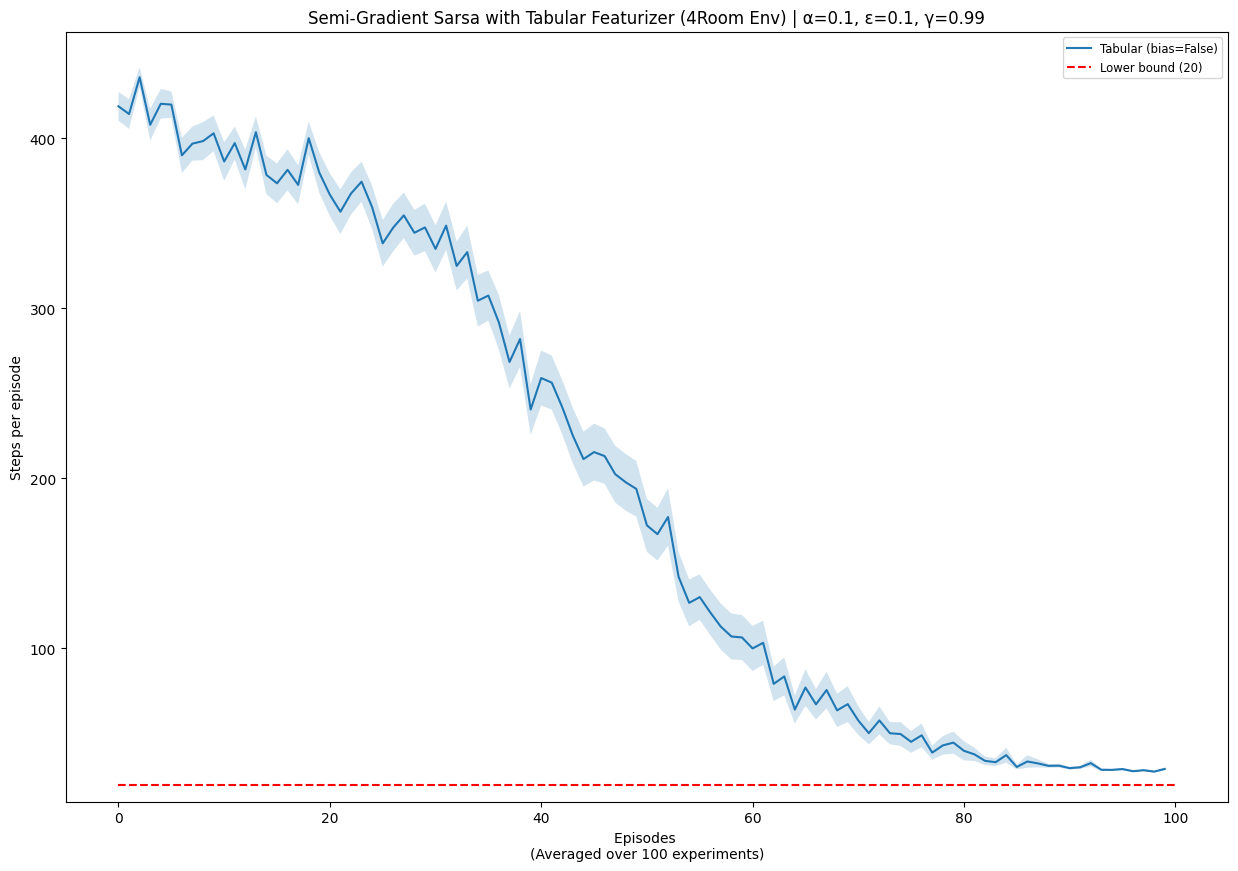

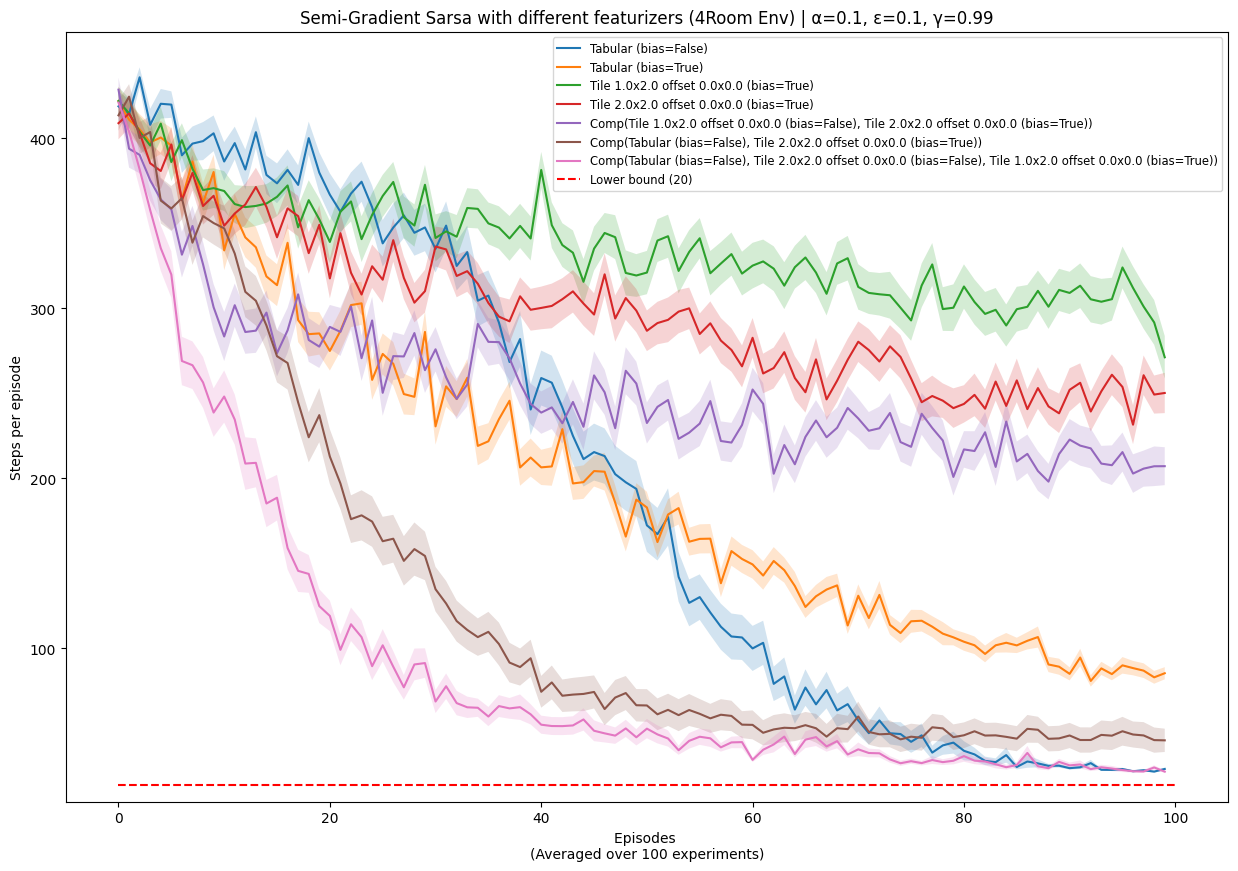

In [16]:
plot_steps_per_episode_experiment(experiment_results[0][np.newaxis], [featurizers[0]], base_config, title=f'Semi-Gradient Sarsa with Tabular Featurizer (4Room Env)', save_path='tabular_featurizer_4Room.png')
plot_steps_per_episode_experiment(experiment_results, featurizers, base_config, title=f'Semi-Gradient Sarsa with different featurizers (4Room Env)', save_path='featurizer_comparison_4Room.png')

In [7]:
metrics = {
    'Featurizer': [str(f) for f in featurizers],
    'Number of features': [f.n_features for f in featurizers],
    'Avg steps per episode': [],
    'Std Dev of Steps/Episode': [],
    'Fastest episode (avg)': [],
    'Slowest episode (avg)': [],
}

for f_ndx in range(len(featurizers)):
    experiment_means = np.mean(experiment_results[f_ndx], axis=0)
    metrics['Avg steps per episode'].append(np.mean(experiment_means))
    metrics['Std Dev of Steps/Episode'].append(np.mean(np.std(experiment_results[f_ndx], axis=0)))
    metrics['Fastest episode (avg)'].append(np.min(experiment_means))
    metrics['Slowest episode (avg)'].append(np.max(experiment_means))
df = pd.DataFrame(metrics).sort_values(by='Number of features')

df_styled = df.style.format({
    'Avg steps per episode': '{:.2f}',
    'Std Dev of Steps/Episode': '{:.2f}',
    'Fastest episode (avg)': '{:.2f}',
    'Slowest episode (avg)': '{:.2f}'
}).set_properties(**{'text-align': 'left'}).hide(axis='index')

# Display the DataFrame
display(df_styled)

Featurizer,Number of features,Avg steps per episode,Std Dev of Steps/Episode,Fastest episode (avg),Slowest episode (avg)
Tile 2.0x2.0 offset 0.0x0.0 (bias=True),41,298.40,119.59,231.56,414.54
Tile 1.0x2.0 offset 0.0x0.0 (bias=True),77,336.44,123.75,271.20,421.88
"Comp(Tile 1.0x2.0 offset 0.0x0.0 (bias=False), Tile 2.0x2.0 offset 0.0x0.0 (bias=True))",117,255.10,122.98,198.09,428.56
Tabular (bias=False),484,200.30,99.99,27.59,435.84
Tabular (bias=True),485,202.34,86.92,80.91,421.80
"Comp(Tabular (bias=False), Tile 2.0x2.0 offset 0.0x0.0 (bias=True))",525,127.55,102.58,45.97,424.44
"Comp(Tabular (bias=False), Tile 2.0x2.0 offset 0.0x0.0 (bias=False), Tile 1.0x2.0 offset 0.0x0.0 (bias=True))",601,91.30,60.13,27.56,420.95


### Taking a Step Back From State Aggregation

Instead of using state aggregation, we can instead just use raw state-action values as our features... 

Let's explore this idea

In [8]:
non_aggregtated_experiment_config = ExperimentConfig(n_experiments=10, n_episodes=100, alpha=0.01)

state_action_featurizer = featurize.StateActionFeaturizer()

In [9]:
SIMPLE_STATE_ACTION_FEATURIZER_PICKLE = "simple_state_action_featurizer.pickle"
try:
    experiment_results_no_aggregation, featurizers_str, config = load_experiment_results(SIMPLE_STATE_ACTION_FEATURIZER_PICKLE)
    if str(non_aggregtated_experiment_config) != config or featurizers_str != featurizers_to_str([state_action_featurizer]):
        raise FileNotFoundError

except FileNotFoundError:
    experiment_results_no_aggregation = run_experiment(env, state_action_featurizer, non_aggregtated_experiment_config)
    save_experiment_results(experiment_results_no_aggregation, [state_action_featurizer], non_aggregtated_experiment_config, SIMPLE_STATE_ACTION_FEATURIZER_PICKLE)

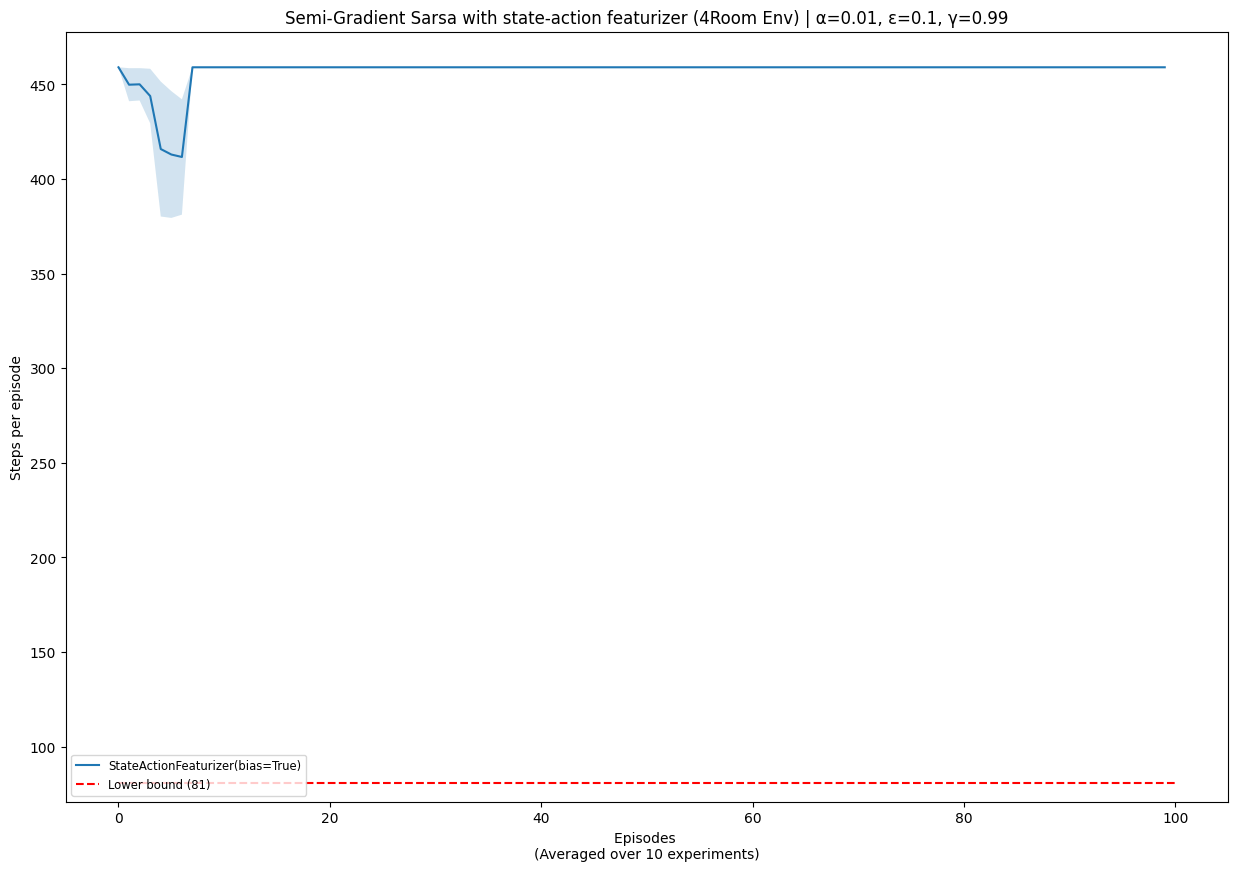

In [10]:
plot_steps_per_episode_experiment(experiment_results_no_aggregation[np.newaxis], [state_action_featurizer], non_aggregtated_experiment_config, title=f'Semi-Gradient Sarsa with state-action featurizer (4Room Env)', save_path='state_action_featurizer_4Room.png')

#### Seems that Simple State Action Features don't work well

This is a simple experiment, however, the outcome can be expected. Since a simple state-action feature representation is way too simple to capture complex relationships between states and actions.

In [11]:
l1_featurizer = featurize.FunctionalFeaturizer(lambda s,a: np.abs(s[0] - env.unwrapped.goal_pos[0]) + np.abs(s[1] - env.unwrapped.goal_pos[1]), label="L1")
l2_featurizer = featurize.FunctionalFeaturizer(lambda s,a: np.sqrt((s[0] - env.unwrapped.goal_pos[0])**2 + (s[1] - env.unwrapped.goal_pos[1])**2), label="L2")
quadrant_featurizer = featurize.FunctionalFeaturizer(lambda s,a: env.unwrapped.get_quadrant(s), label="Quadrant")
state_action_features_with_l1_l2_quadrant = featurize.CompositionFeaturizer([l1_featurizer, l2_featurizer, quadrant_featurizer, state_action_featurizer])

In [12]:
STATE_ACTION_WITH_HEURISTIC_FEATURIZER_PICKLE = "state_action_with_heuristic_featurizer.pickle"

try:
    experiment_results_no_aggregation_hueristics, featurizers_str, config = load_experiment_results(STATE_ACTION_WITH_HEURISTIC_FEATURIZER_PICKLE)
    if str(non_aggregtated_experiment_config) != config or featurizers_str != featurizers_to_str([state_action_features_with_l1_l2_quadrant]):
        raise FileNotFoundError
    
except FileNotFoundError:
    experiment_results_no_aggregation_hueristics = run_experiment(env, state_action_features_with_l1_l2_quadrant, non_aggregtated_experiment_config)
    save_experiment_results(experiment_results_no_aggregation_hueristics, [state_action_features_with_l1_l2_quadrant], non_aggregtated_experiment_config, STATE_ACTION_WITH_HEURISTIC_FEATURIZER_PICKLE)

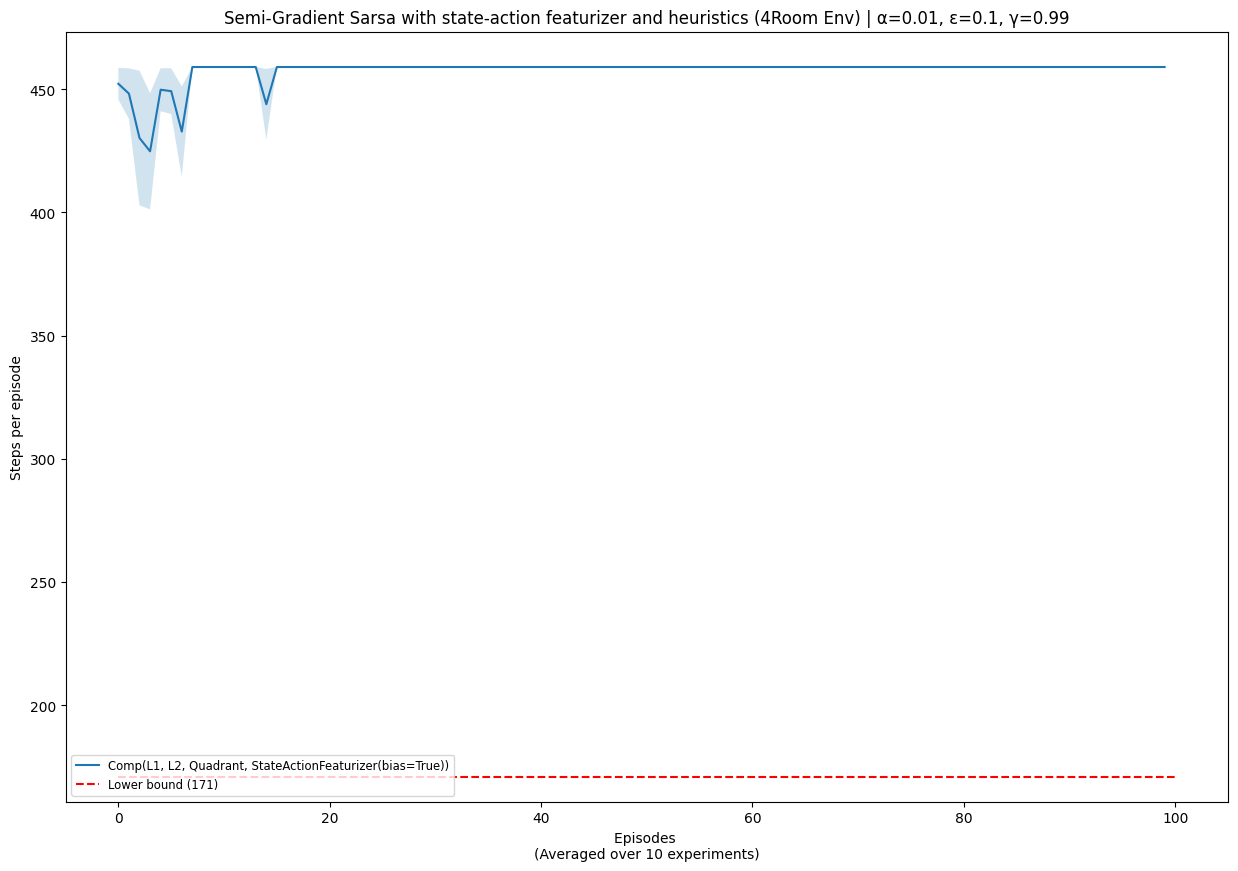

In [13]:
plot_steps_per_episode_experiment(experiment_results_no_aggregation_hueristics[np.newaxis], [state_action_features_with_l1_l2_quadrant], non_aggregtated_experiment_config, title=f'Semi-Gradient Sarsa with state-action featurizer and heuristics (4Room Env)', save_path='state_action_with_heuristics_featurizer_4Room.png')

# Mountain Car

In [14]:
mountain_car_env = gymnasium.make("MountainCar-v0")